## Import libraries

In [18]:
## Import libraries for machine learning and data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
## For random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Import data file
Also contains one hot coded features and scaled features

In [19]:
## import dataset
raw_feature_df_scaled = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_v1.csv')
## Display the first few rows of the dataset
raw_feature_df_scaled.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,time_of_day_Night,location_category_Home,location_category_Other,location_category_School,location_category_Transit,location_category_Work,wake_day_part_0.0,wake_day_part_1.0,wake_day_part_2.0,wake_day_part_3.0
0,certifiedembargobartender@timestudy_com,1,1,0.0,0.0,1,0.995567,0.0,0.000000,0.891772,...,0,0,0,0,1,0,1,0,0,0
1,certifiedembargobartender@timestudy_com,1,1,NaN,NaN,1,0.995567,0.0,0.000000,0.883542,...,0,0,0,0,1,0,1,0,0,0
2,certifiedembargobartender@timestudy_com,0,1,0.0,1.0,0,NaN,1.0,0.301667,0.852631,...,0,0,1,0,0,0,1,0,0,0
3,certifiedembargobartender@timestudy_com,1,1,0.0,1.0,1,0.995567,0.0,0.000000,0.844384,...,0,0,0,0,1,0,1,0,0,0
4,certifiedembargobartender@timestudy_com,1,1,NaN,NaN,0,0.995705,1.0,0.150000,0.831944,...,0,0,0,0,1,0,1,0,0,0


In [20]:
## Inspect the number of unique participant_ids
num_participants = raw_feature_df_scaled['participant_id'].nunique()
print(f"Number of unique participants: {num_participants}")

## Check the shape of the dataset
num_rows, num_cols = raw_feature_df_scaled.shape
print(f"Dataset shape: {num_rows} rows, {num_cols} columns")

## Inspect the data typpes of all columns, except participant_id
raw_feature_df_scaled.dtypes

Number of unique participants: 10
Dataset shape: 108075 rows, 31 columns


participant_id                object
outcome                        int64
is_weekend                     int64
in_battery_saver_mode        float64
charging_status              float64
screen_on                      int64
dist_from_home               float64
is_phone_locked              float64
last_phone_usage             float64
closeness_to_sleep_time      float64
closeness_to_wake_time       float64
mims_5min                    float64
days_in_study                float64
completion_24h               float64
completion_since_wake        float64
completion_since_start       float64
time_of_day_Afternoon          int64
time_of_day_Early Morning      int64
time_of_day_Evening            int64
time_of_day_Late Night         int64
time_of_day_Morning            int64
time_of_day_Night              int64
location_category_Home         int64
location_category_Other        int64
location_category_School       int64
location_category_Transit      int64
location_category_Work         int64
w

## Prepare test and training set
We will keep random 8 users in training set and the two users in test set

In [21]:
import numpy as np
def split_train_test_by_participant_ids(df, id_col='participant_id', n_train=8, random_state=42):
    """
    Randomly selects n_train participant_ids for training, the rest for testing.
    Returns: train_df, test_df
    """
    np.random.seed(random_state)
    unique_ids = df[id_col].unique()
    train_ids = np.random.choice(unique_ids, size=n_train, replace=False)
    test_ids = [pid for pid in unique_ids if pid not in train_ids]
    train_df = df[df[id_col].isin(train_ids)].reset_index(drop=True)
    test_df = df[df[id_col].isin(test_ids)].reset_index(drop=True)
    return train_df, test_df

# Example usage:
train_df, test_df = split_train_test_by_participant_ids(raw_feature_df_scaled)
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"Train participant_ids: {train_df['participant_id'].unique()}")
print(f"Test participant_ids: {test_df['participant_id'].unique()}")

Train set shape: (88178, 31)
Test set shape: (19897, 31)
Train participant_ids: ['certifiedembargobartender@timestudy_com'
 'chewingslouchingfailing@timestudy_com'
 'enjoyergoofinessgrudge@timestudy_com'
 'neutergoldfishsworn@timestudy_com' 'persevereriseswoop@timestudy_com'
 'remoldexcludingaffair@timestudy_com'
 'slapstickporcupineslacks@timestudy_com'
 'subtitlegrievousbazooka@timestudy_com']
Test participant_ids: ['erasuresafeguardravishing@timestudy_com'
 'pretendedconstrainfraying@timestudy_com']


### Inspect the data distribution
We will check number of observations and overall completion rates for each user in test and training dataset

In [22]:
def participant_summary_stats(train_df, test_df, id_col='participant_id', outcome_col='outcome'):
    """
    Returns two DataFrames:
    1. For training set: participant_id, n_observations, completion_rate
    2. For test set: participant_id, n_observations, completion_rate
    """
    def summarize(df):
        counts = df.groupby(id_col).size().rename('n_observations')
        completion = df.groupby(id_col)[outcome_col].mean().rename('completion_rate')
        summary = pd.concat([counts, completion], axis=1).reset_index()
        return summary
    train_summary = summarize(train_df)
    test_summary = summarize(test_df)
    return train_summary, test_summary

# Example usage:
train_summary, test_summary = participant_summary_stats(train_df, test_df)
print('Train set summary:')
print(train_summary)
print('Test set summary:')
print(test_summary)

Train set summary:
                            participant_id  n_observations  completion_rate
0  certifiedembargobartender@timestudy_com           11555         0.804846
1    chewingslouchingfailing@timestudy_com           13283         0.943913
2     enjoyergoofinessgrudge@timestudy_com           10457         0.886488
3        neutergoldfishsworn@timestudy_com            8724         0.885030
4         persevereriseswoop@timestudy_com           12993         0.797045
5      remoldexcludingaffair@timestudy_com            6426         0.737006
6   slapstickporcupineslacks@timestudy_com           11437         0.967387
7    subtitlegrievousbazooka@timestudy_com           13303         0.957604
Test set summary:
                            participant_id  n_observations  completion_rate
0  erasuresafeguardravishing@timestudy_com            4457         0.700247
1  pretendedconstrainfraying@timestudy_com           15440         0.841256


## Train a random forest classifier
We will train it on the entire dataset of 8 users and then test it on 2 users.

In [23]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest_classifier(train_df, outcome_col='outcome', id_col='participant_id', random_state=42, **rf_kwargs):
    """
    Trains a RandomForestClassifier on train_df, using all columns except outcome_col and id_col as features.
    Uses class_weight='balanced' to handle class imbalance in the outcome variable.
    Returns the trained model and the feature column names.
    """
    feature_cols = [col for col in train_df.columns if col not in [outcome_col, id_col]]
    X_train = train_df[feature_cols]
    y_train = train_df[outcome_col]
    clf = RandomForestClassifier(
    random_state=random_state,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=10,
    **rf_kwargs
    )
    clf.fit(X_train, y_train)
    return clf, feature_cols

# Example usage:
rf_model, feature_cols = train_random_forest_classifier(train_df)

## Test the model
On the remaining 2 participants.

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

def evaluate_random_forest_model(model, test_df, feature_cols, outcome_col='outcome'):
    """
    Evaluates the RandomForest model on test_df and returns accuracy, AUC, precision, recall, and F1 scores.
    """
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}" if auc is not None else "AUC: Not available")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return {'accuracy': acc, 'auc': auc, 'precision': precision, 'recall': recall, 'f1': f1}

# Example usage:
metrics = evaluate_random_forest_model(rf_model, test_df, feature_cols)

Accuracy: 0.7432
AUC: 0.7900
Precision: 0.9123
Recall: 0.7555
F1 Score: 0.8265


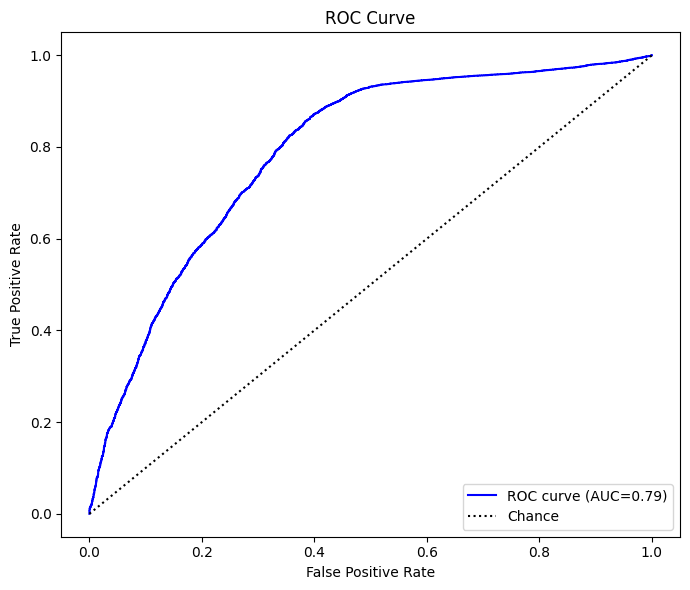

AUC: 0.7900


In [25]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

def plot_roc_curve(model, test_df, feature_cols, outcome_col='outcome'):
    """
    Plots the ROC curve for the model on the test set and prints the AUC.
    """
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    if y_proba is None:
        raise ValueError('Model does not support probability prediction.')
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC={auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k:', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f'AUC: {auc:.4f}')

# Example usage:
plot_roc_curve(rf_model, test_df, feature_cols)

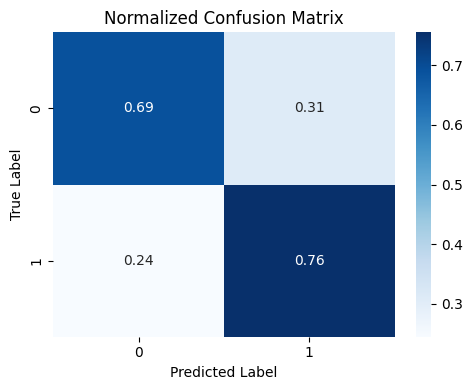

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_df, feature_cols, outcome_col='outcome'):
    """
    Plots the normalized confusion matrix for predicted and ground truth labels on test_df.
    """
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_confusion_matrix(rf_model, test_df, feature_cols)

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_class0_metrics(model, test_df, feature_cols, outcome_col='outcome'):
    """
    Computes and prints precision, recall, and F1 score for class 0 (negative class).
    """
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    y_pred = model.predict(X_test)
    precision_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
    print(f"Class 0 Precision: {precision_0:.4f}")
    print(f"Class 0 Recall: {recall_0:.4f}")
    print(f"Class 0 F1 Score: {f1_0:.4f}")
    return {'precision_0': precision_0, 'recall_0': recall_0, 'f1_0': f1_0}

# Example usage:
compute_class0_metrics(rf_model, test_df, feature_cols)

Class 0 Precision: 0.3992
Class 0 Recall: 0.6910
Class 0 F1 Score: 0.5060


{'precision_0': 0.399176327028676,
 'recall_0': 0.691048323210985,
 'f1_0': 0.5060427342163782}

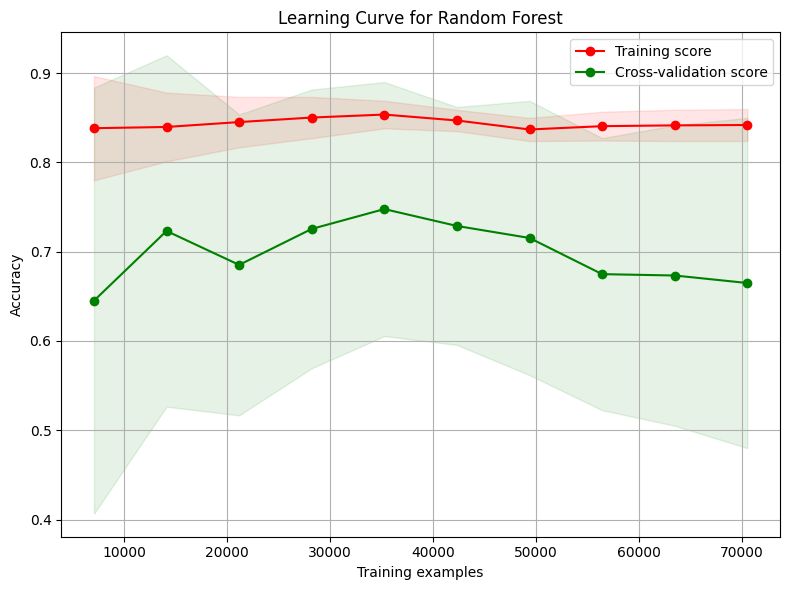

In [28]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42):
    """
    Plots the learning curve for the given model and data.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, random_state=random_state)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.title('Learning Curve for Random Forest')
    plt.xlabel('Training examples')
    plt.ylabel(scoring.capitalize())
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
X = train_df[feature_cols]
y = train_df['outcome']
plot_learning_curve(rf_model, X, y)

In [29]:
def print_rf_hyperparameters(rf_model):
    """
    Prints the main hyperparameters of a Random Forest model.
    """
    print(f"max_depth: {rf_model.max_depth}")
    print(f"min_samples_split: {rf_model.min_samples_split}")
    print(f"min_samples_leaf: {rf_model.min_samples_leaf}")
    print(f"max_features: {rf_model.max_features}")
    print(f"n_estimators: {rf_model.n_estimators}")

# Example usage:
print_rf_hyperparameters(rf_model)

max_depth: 10
min_samples_split: 10
min_samples_leaf: 10
max_features: sqrt
n_estimators: 100


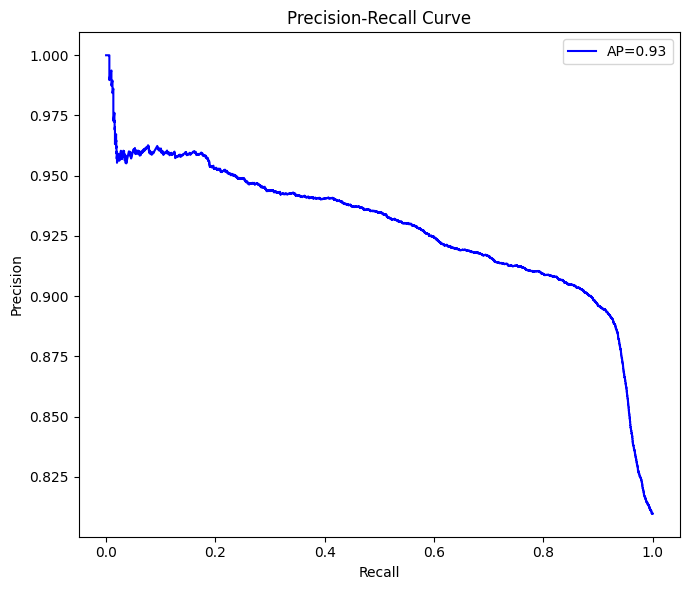

Average Precision Score: 0.9276


In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def plot_precision_recall_curve(model, test_df, feature_cols, outcome_col='outcome'):
    """
    Plots the Precision-Recall curve for the model on the test set and prints the average precision score.
    """
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError('Model does not support probability or decision function output.')
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)
    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, color='b', label=f'AP={avg_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    print(f'Average Precision Score: {avg_precision:.4f}')

# Example usage:
plot_precision_recall_curve(rf_model, test_df, feature_cols)

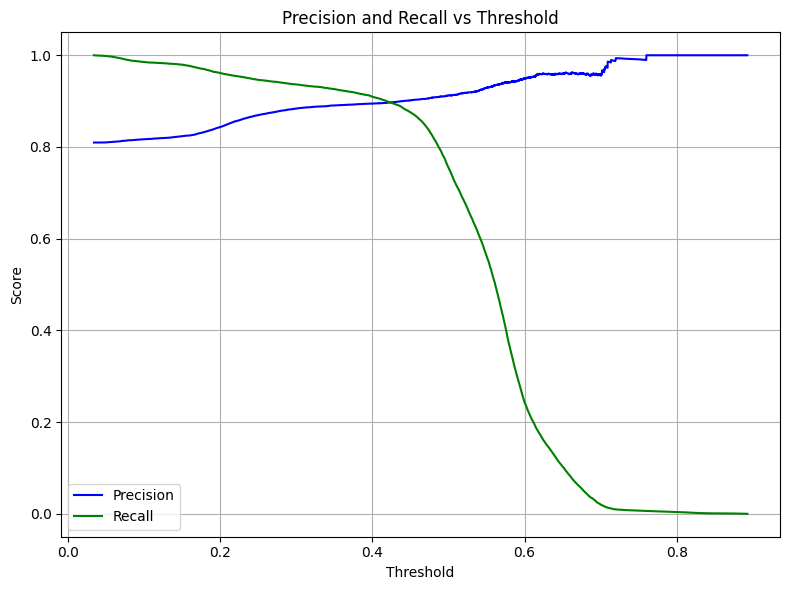

In [31]:
def plot_precision_recall_vs_threshold(model, test_df, feature_cols, outcome_col='outcome'):
    """
    Plots precision and recall as functions of the decision threshold.
    """
    X_test = test_df[feature_cols]
    y_test = test_df[outcome_col]
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError('Model does not support probability or decision function output.')
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision[:-1], label='Precision', color='b')
    plt.plot(thresholds, recall[:-1], label='Recall', color='g')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_precision_recall_vs_threshold(rf_model, test_df, feature_cols)